# Final Project - Group 15 #

**Mary Leung (34578872), Mia Pu (52408770), Takuma Wang (90577297), Thanisha Dhande (29710449)**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction ##

We want to predict whether players (maybe of different gender) will be subscribed to a game-related newsletter based on their age and time spent playing on the Minecraft server.

## Methods and Results ##

In [2]:
players <- read_csv("players.csv")

players_wrangled <- players |>
     mutate(age=Age) |>
    select(subscribe, age, played_hours, experience, gender) |>
    filter(!is.na(age)) |>
    filter(played_hours > 0) |>
    mutate(subscribe=as.factor(subscribe))
# players_wrangled




Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
# assigned 0 or 1 to experience and gender depending on if the obervation was in that category.
# If the obervation was of a Female Pro the columns "experience_Pro" and "Female" would have 1 and the others wouldh have 0.

players_experience <- players |>
    mutate(value=1) |>
    pivot_wider(names_from=experience, 
                names_prefix="experience_",
                values_from=value, 
                values_fill=list(value=0))

players_wrangled <- players_experience |>
    filter(gender %in% c("Male", "Female")) |>
    mutate(value=1) |>
    pivot_wider(names_from=gender,
                values_from=value,
                values_fill=list(value=0)) |>
    select(-hashedEmail, -name) |>
    mutate(subscribe=as.factor(subscribe))
head(players_wrangled)


subscribe,played_hours,Age,experience_Pro,experience_Veteran,experience_Amateur,experience_Regular,experience_Beginner,Male,Female
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRUE,30.3,9,1,0,0,0,0,1,0
TRUE,3.8,17,0,1,0,0,0,1,0
FALSE,0.0,17,0,1,0,0,0,1,0
TRUE,0.7,21,0,0,1,0,0,0,1
TRUE,0.1,21,0,0,0,1,0,1,0
TRUE,0.0,17,0,0,1,0,0,0,1


In [4]:
players_rows <- nrow(players_wrangled)
players_rows

players_selected_6 <- players_wrangled |>
    head(6)
players_selected_6

[1] 161

subscribe,played_hours,Age,experience_Pro,experience_Veteran,experience_Amateur,experience_Regular,experience_Beginner,Male,Female
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRUE,30.3,9,1,0,0,0,0,1,0
TRUE,3.8,17,0,1,0,0,0,1,0
FALSE,0.0,17,0,1,0,0,0,1,0
TRUE,0.7,21,0,0,1,0,0,0,1
TRUE,0.1,21,0,0,0,1,0,1,0
TRUE,0.0,17,0,0,1,0,0,0,1


In [5]:
summary_stats <- summary(players_wrangled)
summary_stats

 subscribe    played_hours          Age        experience_Pro   
 FALSE: 39   Min.   :  0.000   Min.   : 9.00   Min.   :0.00000  
 TRUE :122   1st Qu.:  0.000   1st Qu.:17.00   1st Qu.:0.00000  
             Median :  0.100   Median :19.00   Median :0.00000  
             Mean   :  5.623   Mean   :21.07   Mean   :0.06832  
             3rd Qu.:  0.700   3rd Qu.:22.00   3rd Qu.:0.00000  
             Max.   :223.100   Max.   :58.00   Max.   :1.00000  
 experience_Veteran experience_Amateur experience_Regular experience_Beginner
 Min.   :0.0000     Min.   :0.0000     Min.   :0.0000     Min.   :0.0000     
 1st Qu.:0.0000     1st Qu.:0.0000     1st Qu.:0.0000     1st Qu.:0.0000     
 Median :0.0000     Median :0.0000     Median :0.0000     Median :0.0000     
 Mean   :0.2236     Mean   :0.3354     Mean   :0.1863     Mean   :0.1863     
 3rd Qu.:0.0000     3rd Qu.:1.0000     3rd Qu.:0.0000     3rd Qu.:0.0000     
 Max.   :1.0000     Max.   :1.0000     Max.   :1.0000     Max.   :1.0000     

[Explain the summary]

## Exploratory Data Visualizations ##

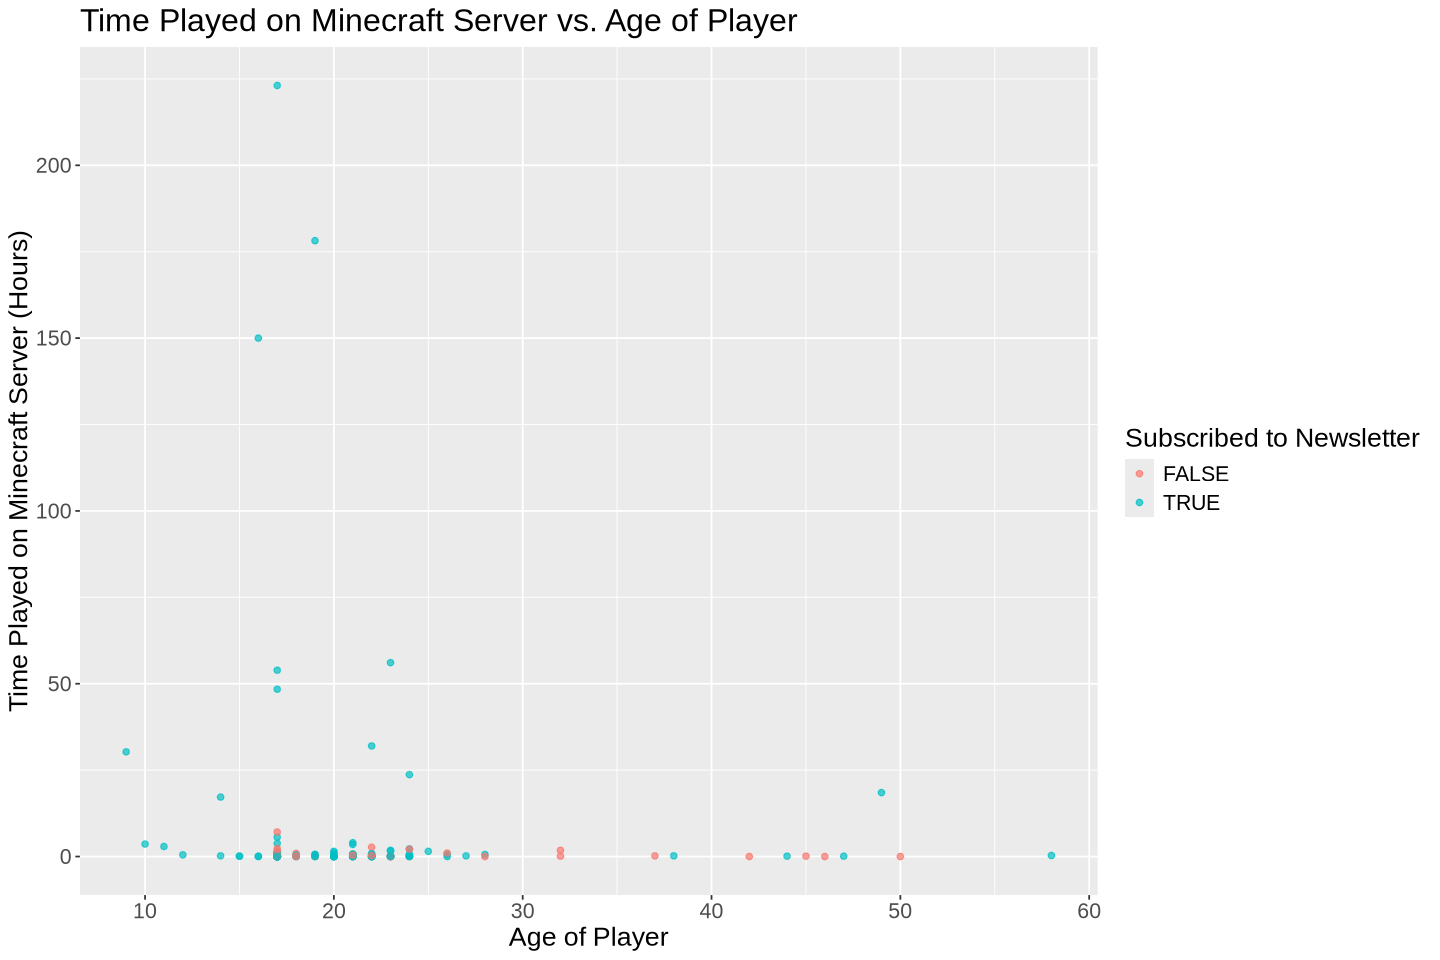

In [6]:
options(repr.plot.width=12, repr.plot.height=8)
players_plot <- ggplot(players_wrangled, aes(x=Age, y=played_hours, color=subscribe)) +
    geom_point(alpha=0.7) +
    labs(x="Age of Player", y="Time Played on Minecraft Server (Hours)", color="Subscribed to Newsletter", 
         title="Time Played on Minecraft Server vs. Age of Player") +
    theme(text=element_text(size=16))
players_plot

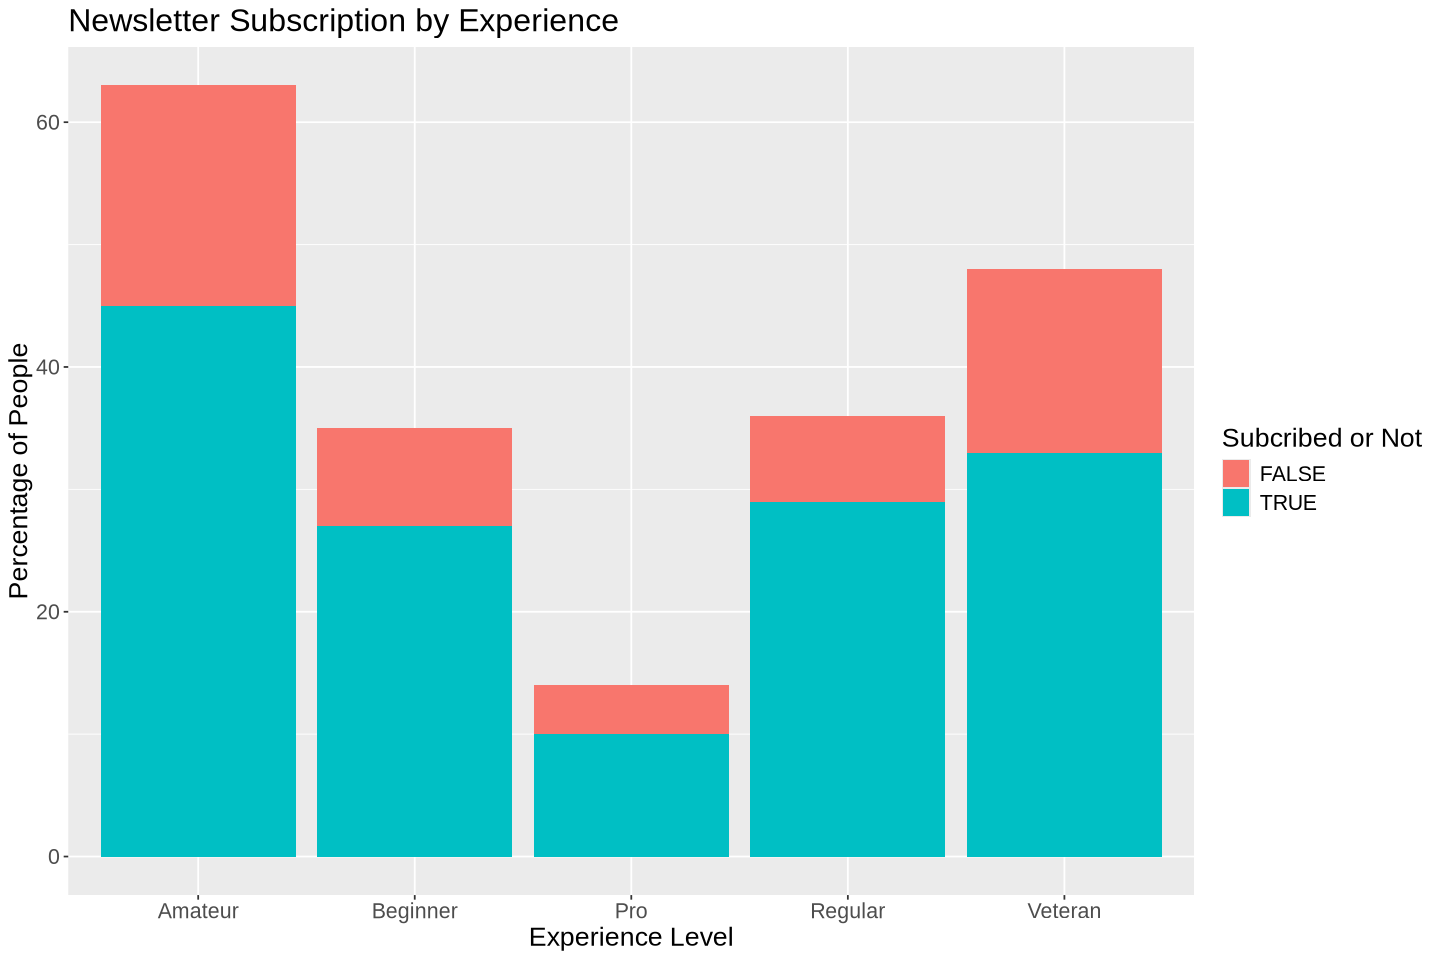

In [7]:
experience_prop_subscribe <- players|>
ggplot(aes(x=experience, fill=subscribe))+
geom_bar(position="stack")+
labs(x="Experience Level", y="Percentage of People", fill = "Subcribed or Not", title="Newsletter Subscription by Experience")+
theme(text=element_text(size=16))
experience_prop_subscribe

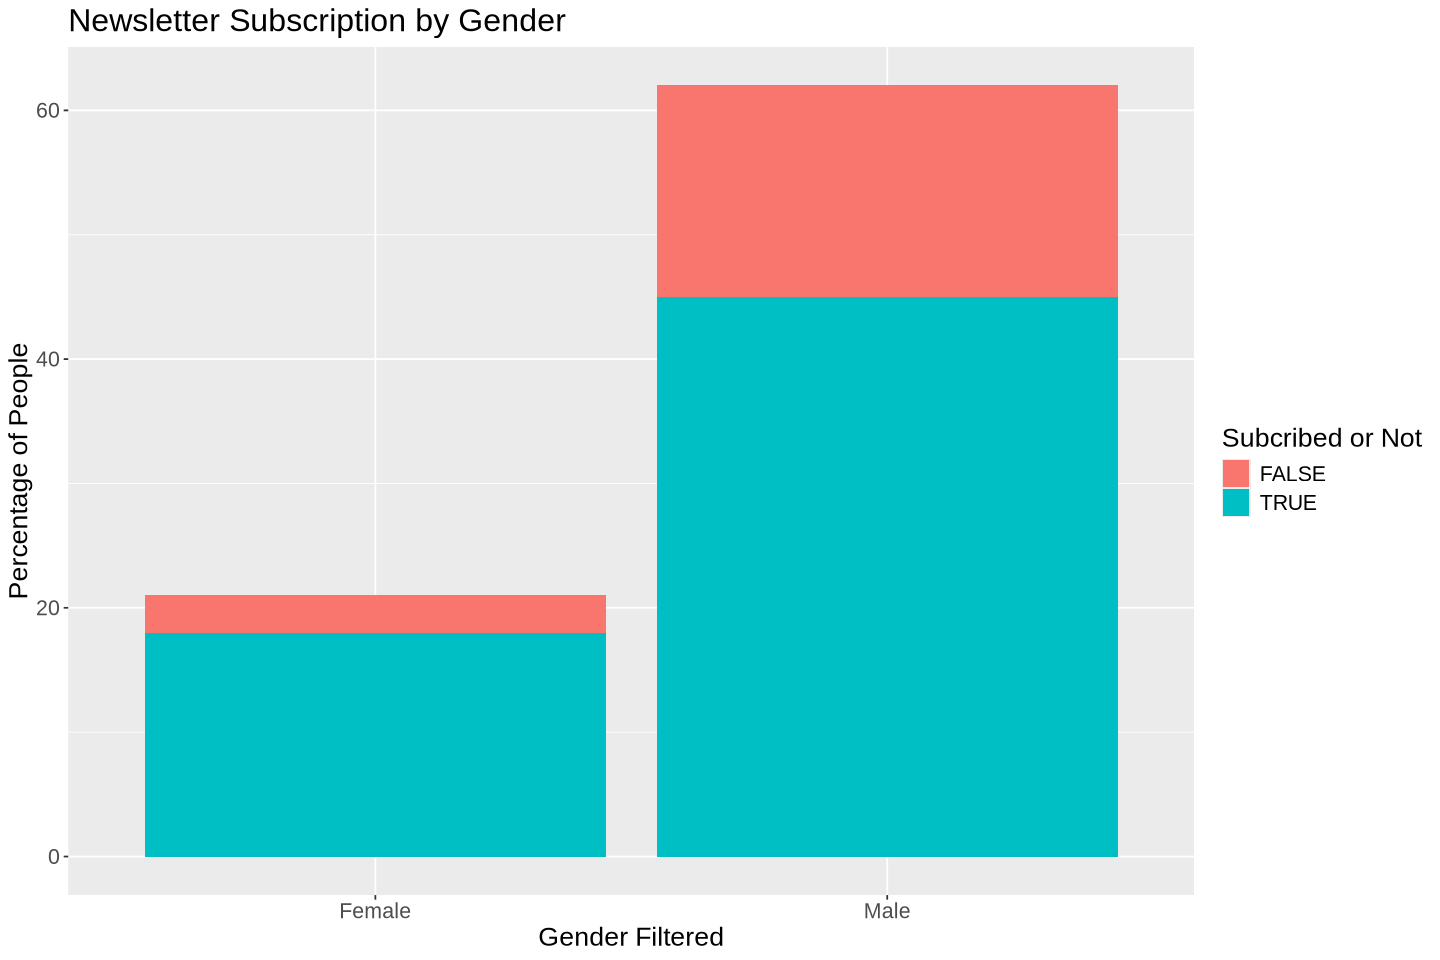

In [8]:
gender_prop_subscribe <- players |>
filter(gender==c("Female", "Male")) |>
ggplot(aes(x=gender, fill=subscribe))+
geom_bar(position="stack")+
labs(x="Gender Filtered", y="Percentage of People", fill = "Subcribed or Not", title="Newsletter Subscription by Gender")+
theme(text=element_text(size=16))
gender_prop_subscribe

In [9]:
set.seed(1)
players_split <- initial_split(players_wrangled, prop=0.7, strat=subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [10]:
set.seed(1)

players_recipe <- recipe(subscribe~., data=players_training) |>
    step_upsample(subscribe, over_ratio=1, skip=TRUE) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())
players_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec

players_vfold <- vfold_cv(players_training, v=5, strata=subscribe)

k_vals <- tibble(neighbors=seq(from=1, to=20, by=1))



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 9



── Operations 

• Up-sampling based on: subscribe

• Centering for: all_predictors()

• Scaling for: all_predictors()



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [11]:
#accuracies of predictor with different k-values, calculated based on training data when making the predictor
training_metrics <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples=players_vfold, grid=k_vals, 
              metrics = metric_set(recall, precision, accuracy)) |>
        collect_metrics() |>
        arrange(desc(mean))
head(training_metrics)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6256917,5,0.03402196,Preprocessor1_Model02
1,accuracy,binary,0.6079051,5,0.03335533,Preprocessor1_Model01
17,accuracy,binary,0.5343874,5,0.05337286,Preprocessor1_Model17
5,accuracy,binary,0.5264822,5,0.01281693,Preprocessor1_Model05
6,accuracy,binary,0.5264822,5,0.01281693,Preprocessor1_Model06
18,accuracy,binary,0.5256917,5,0.05100193,Preprocessor1_Model18


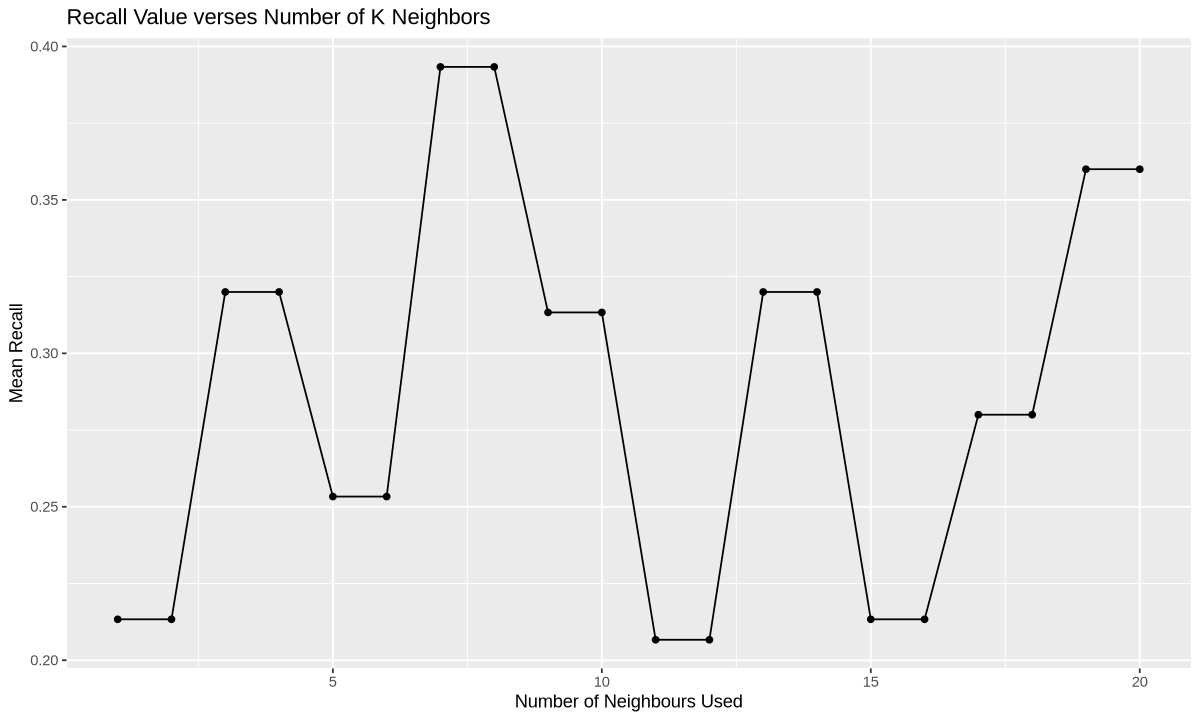

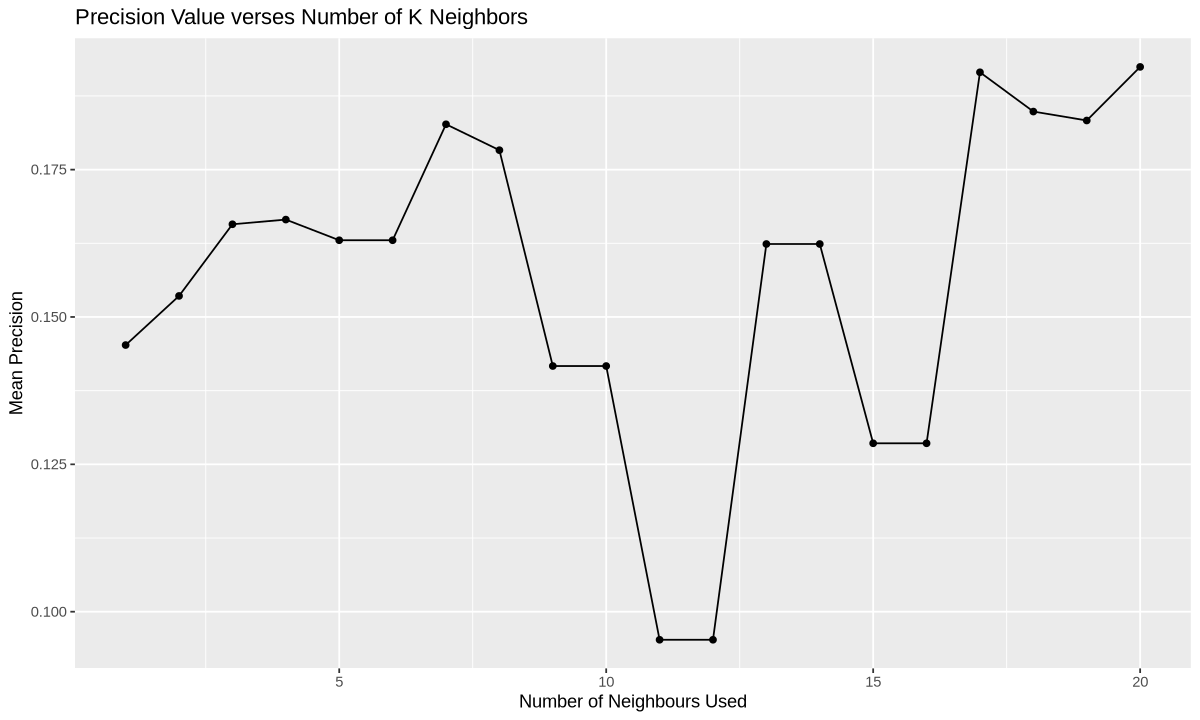

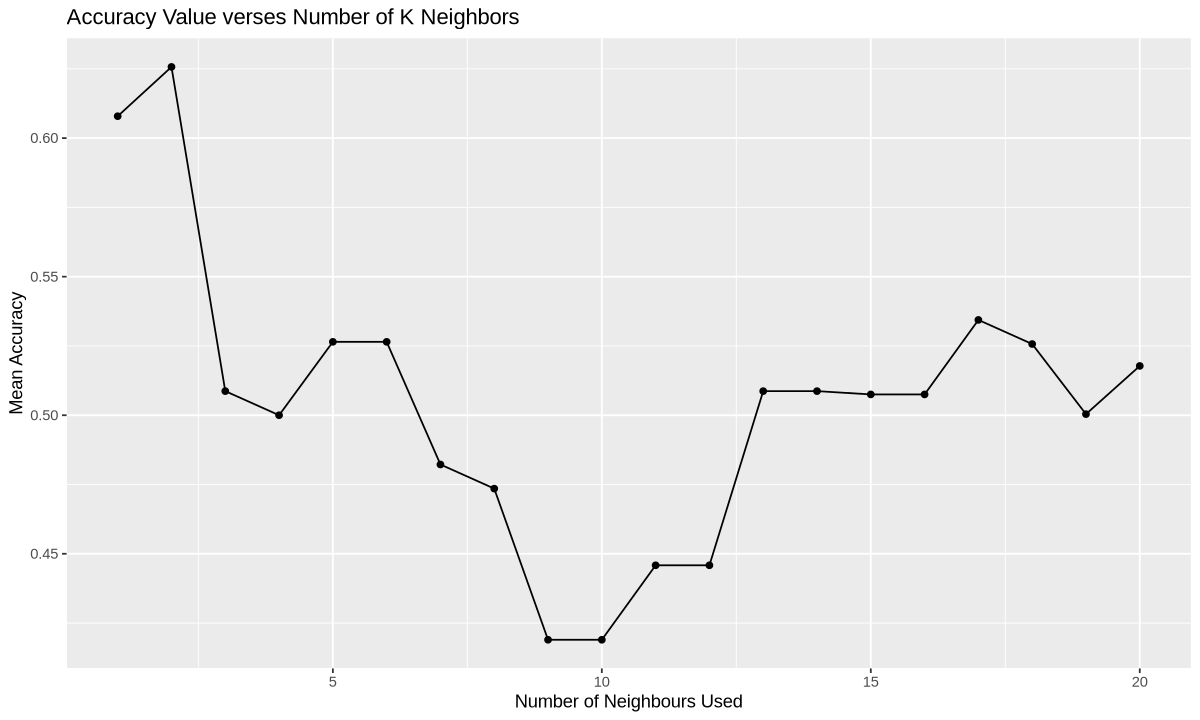

In [12]:
set.seed(1)

recall_tb<- filter(training_metrics, .metric=="recall")

precision_tb<- filter(training_metrics, .metric=="precision")

accuracy_tb<- filter(training_metrics, .metric=="accuracy")

options(repr.plot.width=10, repr.plot.height=6)
recall_plot<- ggplot(recall_tb, aes(x=neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x="Number of Neighbours Used", y= "Mean Recall")+
ggtitle("Recall Value verses Number of K Neighbors")
recall_plot

options(repr.plot.width=10, repr.plot.height=6)
precision_plot<- ggplot(precision_tb, aes(x=neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x="Number of Neighbours Used", y= "Mean Precision")+
ggtitle("Precision Value verses Number of K Neighbors")
precision_plot

options(repr.plot.width=10, repr.plot.height=6)
accuracy_plot<- ggplot(accuracy_tb, aes(x=neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x="Number of Neighbours Used", y= "Mean Accuracy")+
ggtitle("Accuracy Value verses Number of K Neighbors")
accuracy_plot

In [13]:
# Apply k = 2 to training dataset to finalize making predictor
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=2) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data=players_training)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_upsample()
• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2235294
Best kernel: rectangular
Best k: 2

In [14]:
# testing how good our predictor is
# accuracy, precision, and recall values are based on the testing data set

players_test_predictions <- predict(knn_fit, players_testing) |>
  bind_cols(players_testing)
# players_test_predictions

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |> pull(subscribe) |> levels()

players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")


players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")



confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5918367


[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7741935


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6486486


          Truth
Prediction FALSE TRUE
     FALSE     5   13
     TRUE      7   24

we acrnt priortizeing one valueover another so we look at accyracy more than recall

## Discussion ##

ml and tw